Fetch and organize SNODAS

In [99]:
import os
import glob
import shutil
import numpy as np
import regionmask 
import xarray as xr
import rioxarray
import zarr
from datetime import datetime, timedelta
from dask.distributed import Client, LocalCluster
from pathlib import Path
import geopandas as gpd
from validation import SNODAS, MountainHub, Elevation, utils as ut
import matplotlib.pyplot as plt

In [100]:
# given a shapefile, get the bounding box coords and subset dataset to that area
sf_path = Path('/home/spestana/git/Skagit/raw_data/gis/SkagitRiver_BasinBoundary.shp').expanduser()
sf = gpd.read_file(str(sf_path))
#minx, miny, maxx, maxy = sf.geometry[0].bounds

In [101]:
#this_snodas_ds = snodas_ds(datetime(2009,4,10))
#ut.save_netcdf(this_snodas_ds, 'test.nc')
#ds = xr.open_dataset('test.nc')
#ds.Band1.plot()

In [102]:
#start_date = datetime(2009,4,1)
#end_date = datetime(2009,4,3)
#ndays = end_date - start_date
#ndays.days
#
## Fetch data from SNODAS
#print(f'Fetching {ndays.days} days of SNODAS from {start_date} to {end_date}')
#for n, date in enumerate(start_date + timedelta(n) for n in range(ndays.days)):
#    output_path = date.strftime('/data0/images/SNODAS/SNODAS_%Y%m%d.nc')
#    if not os.path.exists(output_path):
#        print(f'Downloading day {n+1} of {ndays.days} to {output_path}', end='\r')
#        try:
#            # download file
#            snodas_ds = SNODAS.snodas_ds(date)
#            ut.save_netcdf(snodas_ds, output_path)
#            # crop to bounds
#            ds = xr.open_dataset(output_path)
#            ds = ds.sel(lat=slice(miny,maxy), lon=slice(minx,maxx))
#            ds.to_netcdf(output_path)
#            ds.close()
#        except Exception as err:
#            print(f"\nError: {err}")

now that it is downloaded, we can work with the data

In [103]:
#ds = xr.open_dataset('/data0/images/SNODAS/skagit/SNODAS_20070401.nc')

In [104]:
#import matplotlib.pyplot as plt
#
##ds = ds.rio.write_crs('epsg:4326')
##ds = ds.rio.clip(sf.geometry, sf.crs, drop=True)
#
#
#fig, ax = plt.subplots()
#ds.Band1.plot(ax=ax, cmap='Blues')
#sf.plot(facecolor='none', edgecolor='r', ax=ax)

-------------------------------

Organize with zarr

In [105]:
def dask_start_cluster(
    workers,
    threads=1,
    ip_address=None,
    port=":8786",
    open_browser=False,
    verbose=True,
):
    """
    Starts a dask cluster. Can provide a custom IP or URL to view the progress dashboard.
    This may be necessary if working on a remote machine.
    """
    cluster = LocalCluster(
        n_workers=workers,
        threads_per_worker=threads,
        #silence_logs=logging.ERROR,
        dashboard_address=port,
    )

    client = Client(cluster)

    if ip_address:
        if ip_address[-1] == "/":
            ip_address = ip_address[:-1]  # remove trailing '/' in case it exists
        port = str(cluster.dashboard_link.split(":")[-1])
        url = ":".join([ip_address, port])
        if verbose:
            print("\n" + "Dask dashboard at:", url)
    else:
        if verbose:
            print("\n" + "Dask dashboard at:", cluster.dashboard_link)
        url = cluster.dashboard_link

    if port not in url:
        if verbose:
            print("Port", port, "already occupied")

    if verbose:
        print("Workers:", workers)
        print("Threads per worker:", threads, "\n")

    if open_browser:
        webbrowser.open(url, new=0, autoraise=True)

    return client

In [106]:
#input_folder = '/data0/images/SNODAS/skagit/'
#zarr_output_path = '/data0/images/SNODAS/skagit/SNODAS_test.zarr'

In [107]:
### outside of prototyping here in this notebook:
### with dask_start_cluster() as client:
###     # do all my processing
### ends client after all the processing steps are done?
##
##
##
#client = dask_start_cluster(
#    workers=6,
#    threads=2,
#    ip_address='http://dshydro.ce.washington.edu',
#    port=":8787",
#    open_browser=False,
#    verbose=True,
#)

In [108]:
## Because the files may not be in a chronological order, we sort them so that the timeseries data we are creating will be in a chronological order.
#
#def get_start_date_from_SNODAS_filename(s):
#    datetime_str = s.split('_')[-1].split('.')[0] # format is YYYYMMDD
#    datetime_object = datetime.strptime(datetime_str, '%Y%m%d')
#    return datetime_object
#
#

add time dim to each file

In [109]:
## SNODAS preprocessing
#
#nc_files = sorted(
#    glob.glob(os.path.join(input_folder, '*.nc')),
#    key=get_start_date_from_SNODAS_filename
#)

In [110]:
## open one file to get the grid we'll match all other files to
#ds_reference = xr.open_dataset(nc_files[-1])
#def fix_grid(ds):
#    # thank you Eric Gagliano
#    return ds.interp_like(ds_reference, method='linear')

In [111]:
## test with random files
## files = [nc_files[int(x)] for x in np.random.uniform(0,len(nc_files),100)] # grab 100 random files
#
#files = nc_files
#datetimes = [get_start_date_from_SNODAS_filename(s) for s in files]
#
#for i,file in enumerate(files):
#    print(f"Processing {i+1} of {len(files)}...", end="\r")
#    new_file_name = file.replace(
#            "/skagit/",
#            "/skagit/withtime/",
#        )
#    if not os.path.exists(new_file_name):
#        try:
#            ds = xr.open_dataset(file, decode_coords="all")
#            ds = ds.assign_coords({"time": datetimes[i]})
#            ds = ds.expand_dims("time")
#            ds = ds.reset_coords(drop=True)
#            ds = ds.rename({'Band1': 'swe'}) # Rename Band1 as a more indicative name: swe
#            ds = fix_grid(ds)
#            da = ds['swe']
#            da = da.rio.write_crs('EPSG:4326')
#            da.to_netcdf(new_file_name)
#        except Exception as err:
#            print(f"Failed on {file}")
#            print(f"Error: {err}")

In [112]:
#nc_files = sorted(
#    glob.glob(os.path.join('/data0/images/SNODAS/skagit/withtime/', '*.nc')),
#    key=get_start_date_from_SNODAS_filename
#)
#

Open multi file dataset

In [113]:
## Open all the raster files as a single dataset (combining them together)
## Why did we choose chunks = 500? 100MB?
## https://docs.xarray.dev/en/stable/user-guide/dask.html#optimization-tips
#ds = xr.open_mfdataset(nc_files, chunks={'time': 100}, ) #preprocess=fix_grid  combine='nested', concat_dim='time',

In [114]:
#ds

In [115]:
#ds.swe.isel(time=48).plot()

In [116]:
## Dask's rechunk documentation: https://docs.dask.org/en/stable/generated/dask.array.rechunk.html
#
## 0:-1 specifies that we want the dataset to be chunked along the 0th dimension -- the time dimension, which means that each chunk will have all 40 thousand values in time dimension
## 1:'auto', 2:'auto' and balance=True specifies that dask can freely rechunk along the latitude and longitude dimensions to attain blocks that have a uniform size
#ds['swe'].data.rechunk(
#    {0:-1, 1:'auto', 2:'auto'}, 
#    block_size_limit=1e8, 
#    balance=True
#)
#
## Assign the dimensions of a chunk to variables to use for encoding afterwards
#t,y,x = ds['swe'].data.chunks[0][0], ds['swe'].data.chunks[1][0], ds['swe'].data.chunks[2][0]
#
#ds['swe'].encoding = {'chunks': (t, y, x)}
#

In [117]:
#ds.swe.isel(time=100).plot()

Clip to watershed area

In [118]:
#ds_clipped = ds.rio.write_crs('epsg:4326')
#ds_clipped = ds_clipped.rio.clip(sf.geometry, sf.crs, drop=True)
#

In [119]:
#ds_clipped.swe.isel(time=100).plot()

In [120]:
# Create an output zarr file and write these chunks to disk
# if already exists, remove it here
#shutil.rmtree(zarr_output_path, ignore_errors=False)

In [121]:
#ds_clipped['swe'].encoding = {'chunks': (t, y, x)}

In [122]:
#ds_clipped.to_zarr(zarr_output_path)

In [123]:
## Display 
#source_group = zarr.open(zarr_output_path)
#source_array = source_group['swe']
#print(source_group.tree())
#print(source_array.info)
#del source_group
#del source_array

In [124]:
client = dask_start_cluster(
                    workers=6,
                    threads=2,
                    ip_address='http://dshydro.ce.washington.edu',
                    port=":8786",
                    open_browser=False,
                    verbose=True,
                    )

/home/spestana/.conda/envs/validation/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8786 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39069 instead
  warnings.warn(



Dask dashboard at: http://dshydro.ce.washington.edu:39069/status
Workers: 6
Threads per worker: 2 



Get basin mean SWE:

In [125]:
ds_clipped = xr.open_zarr('/data0/images/SNODAS/skagit/SNODAS_skagit.zarr')
ds_clipped = ds_clipped.where(ds_clipped.lat<=49)

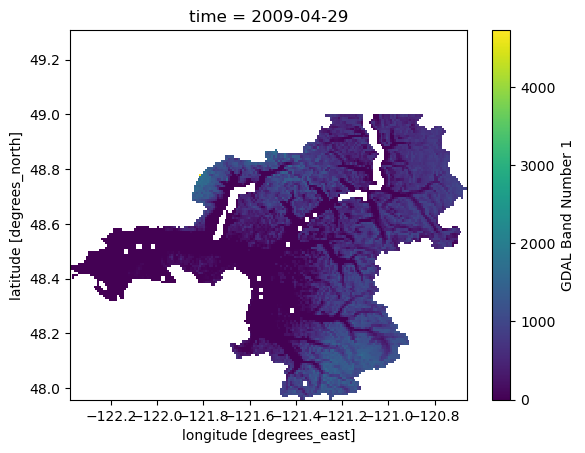

In [126]:
ds_clipped.isel(time=2020).swe.plot()

In [127]:
ds_mean_swe = ds_clipped.swe.mean(axis=(1,2)) / 1000 # scale factor of 1000
ds_median_swe = ds_clipped.swe.median(axis=(1,2)) / 1000 # scale factor of 1000
ds_q25_swe = ds_clipped.swe.quantile(0.25, dim=['lon','lat']) / 1000 # scale factor of 1000
ds_q75_swe = ds_clipped.swe.quantile(0.75, dim=['lon','lat']) / 1000 # scale factor of 1000

Text(0, 0.5, 'Mean SWE, m')

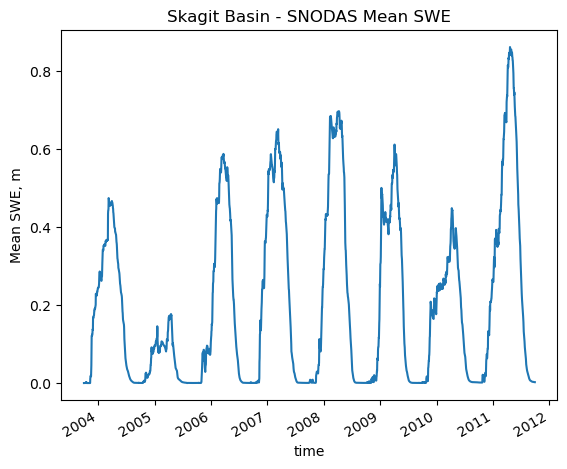

In [128]:
ds_mean_swe.plot()
plt.title('Skagit Basin - SNODAS Mean SWE')
plt.ylabel('Mean SWE, m')

In [129]:
df_mean_swe = ds_mean_swe.to_dataframe()

In [130]:
df_mean_swe.to_csv('SNODAS_SkagitBasin_meanSWE_CONUS.csv')

Now get SWE at the three SNOTEL locations:

In [131]:
from metloom.pointdata import SnotelPointData
from metloom.variables import SensorDescription, SnotelVariables

In [132]:
variables = [SnotelPointData.ALLOWED_VARIABLES.SNOWDEPTH,
            SnotelPointData.ALLOWED_VARIABLES.SWE,
            SnotelPointData.ALLOWED_VARIABLES.PRECIPITATION,
            SnotelPointData.ALLOWED_VARIABLES.TEMP,
            SnotelPointData.ALLOWED_VARIABLES.RH,]

#variables = [SnotelPointData.ALLOWED_VARIABLES.PRECIPITATION]

# Find all the points in the area for our variables
points = SnotelPointData.points_from_geometry(sf, variables)
print(len(points))
# This is an iterator
print(type(points))
# It contains the points in a `points` attribute
print(points.points)

# turn that iterator into a dataframe
pts_df = points.to_dataframe()
# look at what is in the dataframe
pts_df.head(10)


8
<class 'metloom.pointdata.base.PointDataCollection'>
[SnotelPointData('999:WA:SNTL', 'Marten Ridge'), SnotelPointData('1080:WA:SNTL', 'Brown Top'), SnotelPointData('998:WA:SNTL', 'Easy Pass'), SnotelPointData('990:WA:SNTL', 'Beaver Pass'), SnotelPointData('991:WA:SNTL', 'Hozomeen Camp'), SnotelPointData('817:WA:SNTL', 'Thunder Basin'), SnotelPointData('975:WA:SNTL', 'Swamp Creek'), SnotelPointData('711:WA:SNTL', 'Rainy Pass')]


,name,id,datasource,geometry
0,Marten Ridge,999:WA:SNTL,NRCS,POINT Z (-121.69823 48.76292 3520.00000)
1,Brown Top,1080:WA:SNTL,NRCS,POINT Z (-121.19713 48.92755 5830.00000)
2,Easy Pass,998:WA:SNTL,NRCS,POINT Z (-121.43895 48.85933 5270.00000)
3,Beaver Pass,990:WA:SNTL,NRCS,POINT Z (-121.25550 48.87930 3630.00000)
4,Hozomeen Camp,991:WA:SNTL,NRCS,POINT Z (-121.07976 48.98075 1690.00000)
5,Thunder Basin,817:WA:SNTL,NRCS,POINT Z (-120.98950 48.52753 4320.00000)
6,Swamp Creek,975:WA:SNTL,NRCS,POINT Z (-120.78267 48.57142 3930.00000)
7,Rainy Pass,711:WA:SNTL,NRCS,POINT Z (-120.73580 48.51865 4890.00000)


In [146]:
point.geometry.x.values

array([-120.9895])

In [151]:
point = pts_df[pts_df['name']=="Thunder Basin"]
ds_pt = ds_clipped.sel(lon=point.geometry.x.values, lat=point.geometry.y.values, method='nearest').swe


point2 = pts_df[pts_df['name']=="Rainy Pass"]
ds_pt2 = ds_clipped.sel(lon=point2.geometry.x.values, lat=point2.geometry.y.values, method='nearest').swe

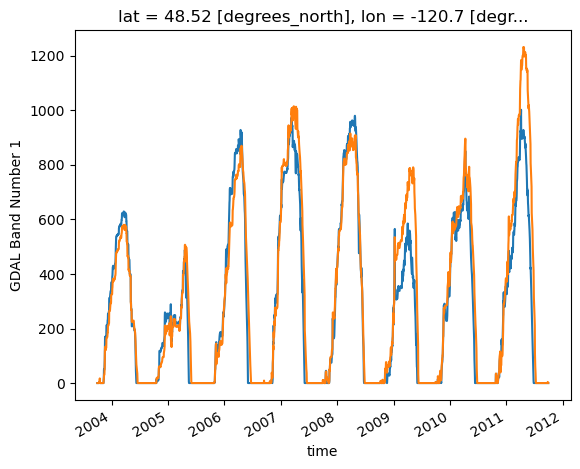

In [152]:
ds_pt.plot()
ds_pt2.plot()

In [84]:
for i, point in pts_df.iterrows():
    ds_pt = ds_clipped.sel(lon=point.geometry.x, lat=point.geometry.y, method='nearest').swe
    df_pt = ds_pt.to_dataframe()
    out_filename = f'{point['name'].replace(' ','')}_{point['id'].replace(':','_')}.csv'
    df_mean_swe.to_csv(out_filename)

---






/home/spestana/.conda/envs/validation/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 45.38 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Text(0, 0.5, 'Mean SWE, m')

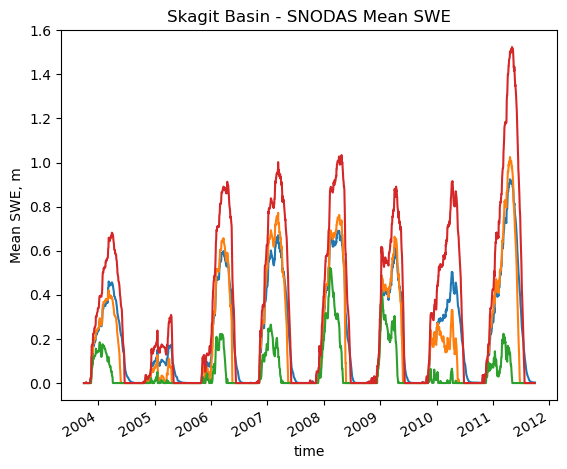

In [22]:
ds_mean_swe.plot()
ds_median_swe.plot()
ds_q25_swe.plot()
ds_q75_swe.plot()

plt.title('Skagit Basin - SNODAS Mean SWE')
plt.ylabel('Mean SWE, m')

In [24]:
lon = ds_clipped.lon
lat = ds_clipped.lat

mask = regionmask.mask_geopandas(sf, lon, lat) + 1

In [25]:
total_area = mask.sum()

In [26]:
ds_clipped_masked = ds_clipped.where(mask) 

In [27]:
ds_clipped_masked['binary_snow'] = ds_clipped_masked.swe > 0

In [28]:
binary_snow_timeseries = ds_clipped_masked.binary_snow.sum(axis=(1,2))

In [29]:
sca_timeseries = (binary_snow_timeseries / total_area)

/home/spestana/.conda/envs/validation/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 51.43 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


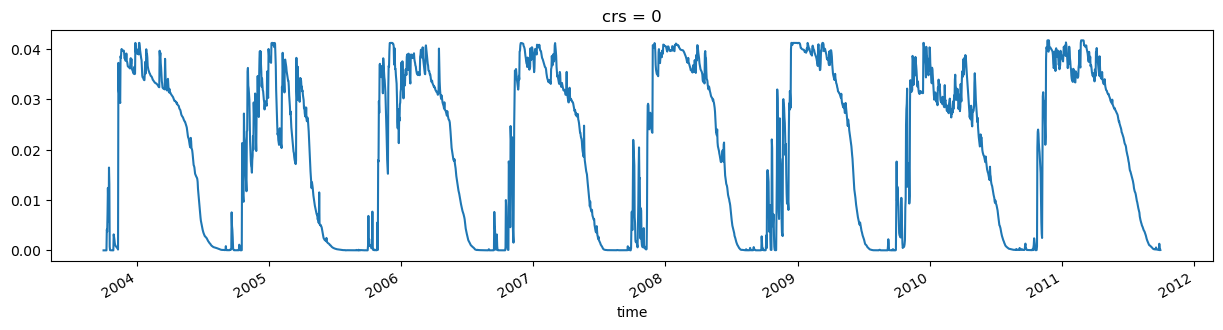

In [30]:
sca_timeseries.plot(figsize=(15,3))

---